In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path)

NS_dict_keys = ['2024-10-15_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan']
NS_bins = SMPS['2024-10-21_NanoScan'].keys()[3:16].to_list()

NS_bg_mean, NS_bg_std, NS_bg_error = bin_mean(['2024/10/21 11:45:00', '2024/10/21 14:10:00'], 
                                              SMPS['2024-10-21_NanoScan'], NS_bins, 'Time', 0.1)

for key in NS_dict_keys:
    df = SMPS[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS_bg_mean[i]

    SMPS[key] = df

dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()

for dict_key in dict_keys:
    for old_key, new_key in zip(OPS_bins, OPS_mid_point):
        OPS_APS[dict_key] = OPS_APS[dict_key].rename(columns = {old_key: new_key})

APS_dict_keys = ['20241016_APS', '20241016_APS_2_exp', '20241017_APS', '20241017_APS']
APS_bins = OPS_APS['20241016_APS'].keys()[2:53].to_list()
APS_bin_mean = []
for key in OPS_APS['20241016_APS'].keys()[2:53]:
    APS_bin_mean.append(float(key))
    OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce') * 7.86

APS_number = pd.DataFrame({'Time': OPS_APS['20241016_APS']['Time']})
for i, key in enumerate(APS_bins):
    # Ensure df[key] is numeric
    OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce')
    
    APS_number[key] = OPS_APS['20241016_APS'][key] / ((7.86 / 10**6) * (np.pi / 6) * APS_bin_mean[i]**3 * 10**6) # in #/cm**3
OPS_APS['20241016_APS'] = APS_number

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,
Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [3]:
time_wBG = [['2024-10-16 09:50:00', '2024-10-16 12:50:00'],
            ['2024-10-16 14:30:00', '2024-10-16 16:30:00'],
            ['2024-10-17 09:30:00', '2024-10-17 12:10:00'],
            ['2024-10-17 14:10:00', '2024-10-17 15:30:00']]

In [4]:
SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']
SMPS_APS_number, SMPS_APS_mass, SMPS_APS_keys, SMPS_APS_bin_mean = merge_data(SMPS, SMPS_dict_keys, [4, 109], OPS_APS, APS_dict_keys, [6, 53], time_wBG, ['Time', 'Time'], True, False)

NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NS_OPS_number, NS_OPS_mass, NS_OPS_keys, NS_OPS_bin_mean = merge_data(SMPS, NanoScan_dict_keys, [3, 15], OPS_APS, dict_keys, [1, 17], time_wBG, ['Time', 'Time'], False, True)

SMPS_OPS_number, SMPS_OPS_mass, SMPS_OPS_keys, SMPS_OPS_bin_mean = merge_data(SMPS, SMPS_dict_keys, [4, 89], OPS_APS, dict_keys, [2, 17], time_wBG, ['Time', 'Time'], True, True)

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\calculations.py:316: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_small['Time'] = pd.to_datetime(df_small.index)
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\calculations.py:316: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_small['Time'] = pd.to_datetime(df_small.index)
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\calculations.py:316: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

In [5]:
timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

ax_labels = ['Particle diameter / $\mu$m', 'dN / #/cm$^{3}$', 'dM / $\mu$g/m$^{3}$']

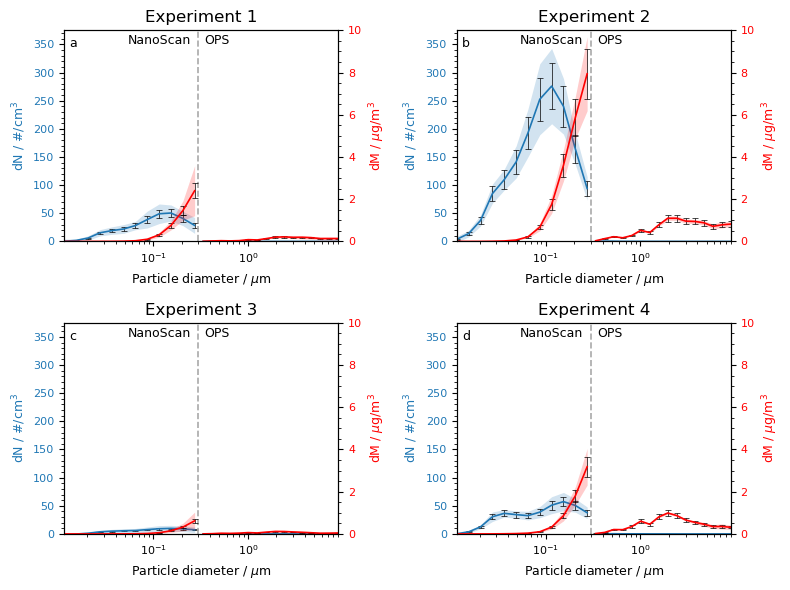

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], NS_OPS_number[key], NS_OPS_mass[key], NS_OPS_keys, 'Time', NS_OPS_bin_mean, ['tab:blue', 'red'], 0.15, ax_labels, True, 0.3)
    ax.vlines(0.3, 0, 400, colors = 'darkgrey', linestyles = '--')
    ax.text(0.25, 350, 'NanoScan', ha = 'right', fontsize = 9)
    ax.text(0.35, 350, 'OPS', ha = 'left', fontsize = 9)
    # ax.set_xlim(min(OPS_mid_point) - 0.01, max(OPS_mid_point) + 0.3)
    ax.set_ylim(0, 375)
    ax2.set_ylim(0, 10)
    
    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 9)

fig.tight_layout()
fig.savefig('Mean_concentrations/Nano_OPS_mean.png', dpi = 600)

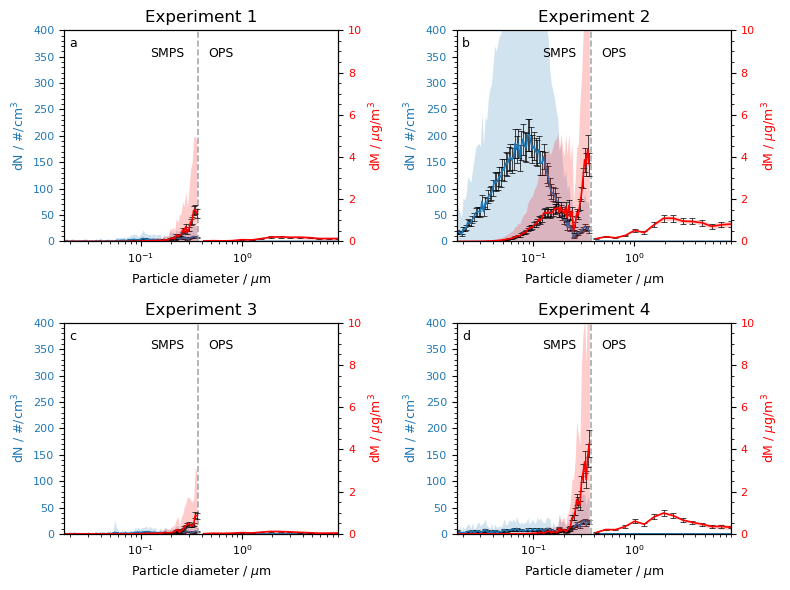

In [7]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], SMPS_OPS_number[key], SMPS_OPS_mass[key], SMPS_OPS_keys, 'Time', SMPS_OPS_bin_mean, ['tab:blue', 'red'], 0.15, ax_labels, True, 0.37)
    ax.vlines(0.37, 0, 400, colors = 'darkgrey', linestyles = '--')
    ax.text(0.27, 350, 'SMPS', ha = 'right', fontsize = 9)
    ax.text(0.47, 350, 'OPS', ha = 'left', fontsize = 9)
    # ax.set_xlim(min(OPS_mid_point) - 0.01, max(OPS_mid_point) + 0.3)
    ax.set_ylim(0, 400)
    ax2.set_ylim(0, 10)
    
    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 9)

fig.tight_layout()
fig.savefig('Mean_concentrations/SMPS_OPS_mean.png', dpi = 600)

In [8]:
NS_OPS_cut = [0.010, 0.0132, 0.0179, 0.0234, 0.032, 0.0416, 0.057, 0.0739, 0.1015, 0.1314, 0.1805, 0.2337, 
              0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:237: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-45, ha="left")


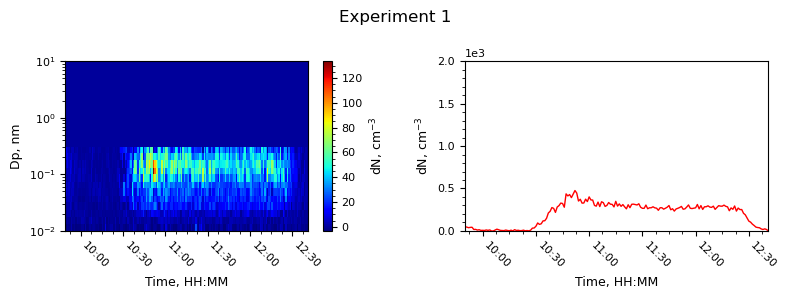

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:237: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-45, ha="left")


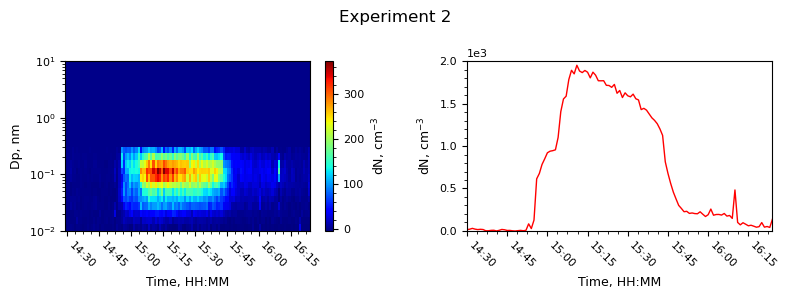

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:237: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-45, ha="left")


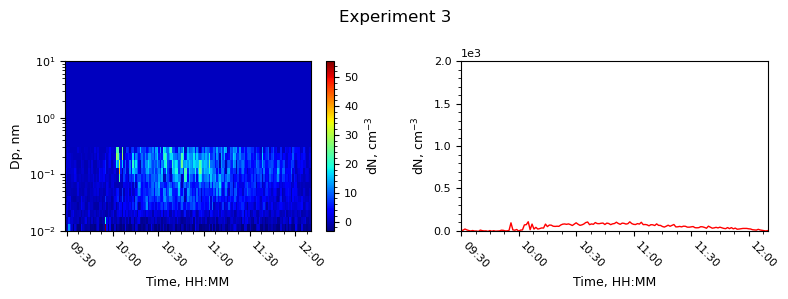

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:237: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-45, ha="left")


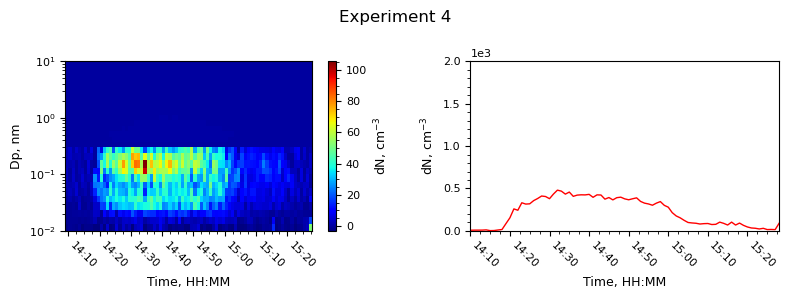

In [9]:
for i, key in enumerate(dict_keys):
    name = 'Timeseries/NS-OPS_timeseries_number_' + key + '.png'

    fig, ax = plt.subplots(1, 2, figsize = (8, 3))

    plot_timeseries(fig, ax, NS_OPS_number[key], NS_OPS_keys, NS_OPS_cut, 'number', time_wBG[i])

    ax[1].set_ylim(0, 2000)

    title = 'Experiment ' + str(i + 1)
    fig.suptitle(title)

    fig.tight_layout()
    fig.savefig(name, dpi = 600)
    plt.show()

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:237: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-45, ha="left")


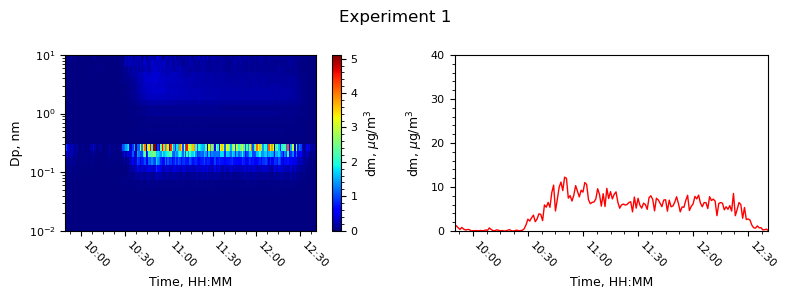

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:237: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-45, ha="left")


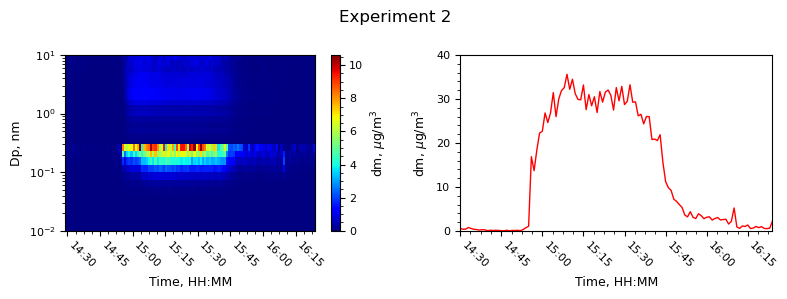

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:237: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-45, ha="left")


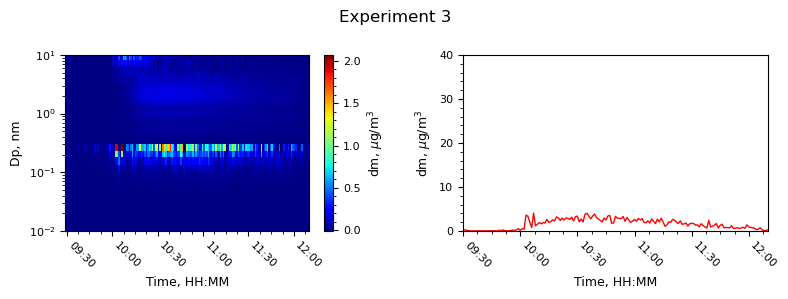

c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:237: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-45, ha="left")
c:\Users\B363580\Documents\GitHub\Master-thesis\Lund Brake Wear\..\plot_functions.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=-45, ha="left")


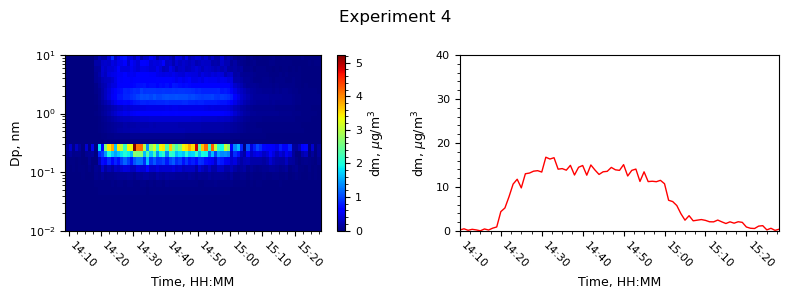

In [10]:
for i, key in enumerate(dict_keys):
    name = 'Timeseries/NS-OPS_timeseries_mass_' + key + '.png'

    fig, ax = plt.subplots(1, 2, figsize = (8, 3))

    plot_timeseries(fig, ax, NS_OPS_mass[key], NS_OPS_keys, NS_OPS_cut, 'mass', time_wBG[i])

    ax[1].set_ylim(0, 40)

    title = 'Experiment ' + str(i + 1)
    fig.suptitle(title)

    fig.tight_layout()
    fig.savefig(name, dpi = 600)
    plt.show()